From PXD030595 (HCD) take raw data "2021-5-21_Otter_v9.raw"


To convert raw data: mono /home/tribiosis/install/ThermoRawFileParser/ThermoRawFileParser.exe -i=/home/tribiosis/Master/master_thesis/prepro_test/2021-5-21_Otter_v9.raw -o=/home/tribiosis/Master/master_thesis/prepro_test/ -f=0 -g -m=0

In [1]:
import numpy as np
import pandas as pd
from pyteomics import mgf
import matplotlib.pyplot as plt

In [2]:
reader = mgf.read('test.mgf')
for spectrum in reader:
    print(spectrum["params"]["pepmass"][0], int(str(spectrum["params"]["charge"][0])[:1]))

765.797485351563 2
399.349365234375 2


In [3]:
reader = mgf.read('test.mgf')
for spectrum in reader:
    print(spectrum["intensity array"])

[ 5909.70117188  7664.00683594  8281.00195312  7887.60986328
  8942.16503906  7136.56396484  8047.40185547 10000.33333333]
[ 4071.96533203  6770.89697266  4803.41113281  4926.58984375
  8080.02294922  6177.65283203  7475.65625     5837.67724609
  6427.96142578  6950.28662109 10061.36035156 12399.53515625
  6932.38183594]


"Rank_TIC normalizes I(pi) in P by computing the sum of all raw intensities I(pk) in P that are smaller than I(pi) and dividing this sum by the total ion current of P. So,the highest peak I(pj) equals 1. All other peaks pi are scaled relative to the total ion current of all peaks (that are less abundant than pi)". This last part in the parenthesis is not true, otherwise all peaks will be more than 1. It's always divided by the TIC, which accounts for every peak in the spectrum.

In [4]:
def rank_TIC_normalization(input_file, output_file):

    """
    Normalizes spectra intensities taking into account their rank and the total ion current.
    
    Parameters
    ----------
        input_file : path to the mgf file to normalize
        output_file : name of the mgf file normalized
        
    Returns
    -------
        Nothing, it writes an mgf file with the intensities normalized 
    """
    reader = mgf.read(input_file)
    for spectrum in reader:
        spec_len = len(spectrum["intensity array"]) # Number of ions in MS2 spectrum
        TIC = np.sum(spectrum["intensity array"]) # Total ion current
        original_order = spectrum["intensity array"].argsort().argsort() # get index to restore order
        sorted_int = np.sort(spectrum["intensity array"])
        normalized = np.zeros([spec_len,])
        for index in range(spec_len):
            normalized[index] = np.sum(sorted_int[:index+1])/TIC
        spectrum["intensity array"] = normalized[original_order]
        mgf.write((spectrum,), output_file, file_mode='a')


In [5]:
rank_TIC_normalization("test.mgf", "normalized_test.mgf")

In [6]:
def plot_spectrum(input_file, title):
    reader = mgf.read(input_file)
    for spectrum in reader:
        y = spectrum["intensity array"]
        x = spectrum["m/z array"]
        zipped = list(zip(x, y))
        df = pd.DataFrame(zipped, columns=['m/z', 'Intensity'])
        plt.stem('m/z', 'Intensity', data=df, basefmt="C2", linefmt='black', label= "m/z values")
        plt.ylabel('Intensity')
        plt.xlabel('m/z')
        plt.title(title)
        plt.show()

In [9]:
def plot_spectrum_from_reader(spectrum, title):
    y = spectrum["intensity array"]
    x = spectrum["m/z array"]
    zipped = list(zip(x, y))
    df = pd.DataFrame(zipped, columns=['m/z', 'Intensity'])
    plt.stem('m/z', 'Intensity', data=df, basefmt="C2", linefmt='black', label= "m/z values")
    plt.ylabel('Intensity')
    plt.xlabel('m/z')
    plt.title(title)
    plt.show()

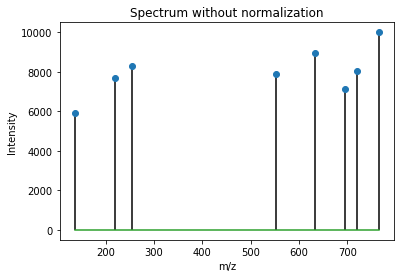

In [10]:
reader = mgf.read('test.mgf')
for spectrum in reader[0:1]: #read the first uncalibrated spectrum 
    plot_spectrum_from_reader(spectrum, "Spectrum without normalization")

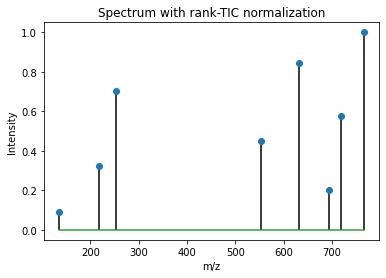

In [12]:
reader = mgf.read('normalized_test.mgf')
for spectrum in reader[0:1]: #read the first uncalibrated spectrum 
    plot_spectrum_from_reader(spectrum, "Spectrum with rank-TIC normalization")

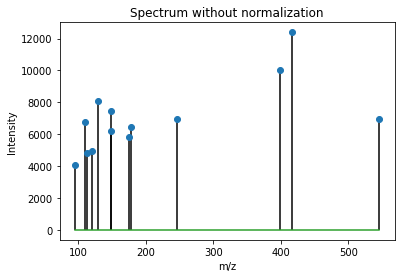

In [13]:
reader = mgf.read('test.mgf')
for spectrum in reader[1:2]: #read the first uncalibrated spectrum 
    plot_spectrum_from_reader(spectrum, "Spectrum without normalization")

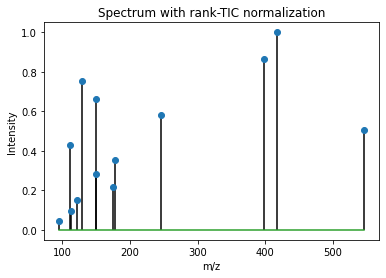

In [14]:
reader = mgf.read('normalized_test.mgf')
for spectrum in reader[1:2]: #read the first uncalibrated spectrum 
    plot_spectrum_from_reader(spectrum, "Spectrum with rank-TIC normalization")

In [ ]:
import time
start = time.time()
rank_TIC_normalization("data.mgf", "normalized_long.mgf")
end = time.time()
print ("Time elapsed normalizing mgf file of 151M:", end - start)

Function to remove precursion fragment ion from spectrum_utils

In [15]:
def mass_diff(mz1, mz2, mode_is_da):
    """
    Calculate the mass difference(s).
    Parameters
    ----------
    mz1
        First m/z value(s).
    mz2
        Second m/z value(s).
    mode_is_da : bool
        Mass difference in Dalton (True) or in ppm (False).
    Returns
    -------
        The mass difference(s) between the given m/z values.
    """
    return mz1 - mz2 if mode_is_da else (mz1 - mz2) / mz2 * 10 ** 6

In [16]:
def _get_non_precursor_peak_mask(
    mz: np.ndarray,
    pep_mass: float,
    max_charge: int,
    isotope: int,
    fragment_tol_mass: float,
    fragment_tol_mode: str,
) -> np.ndarray:
    """
    Get a mask to remove peaks that are close to the precursor mass peak (at
    different charges and isotopes).
    JIT helper function for `MsmsSpectrum.remove_precursor_peak`.
    Parameters
    ----------
    mz : np.ndarray
        The mass-to-charge ratios of the spectrum fragment peaks.
    pep_mass : float
        The mono-isotopic mass of the uncharged peptide.
    max_charge : int
        The maximum precursor loss charge.
    isotope : int
        The number of isotopic peaks to be checked.
    fragment_tol_mass : float
            Fragment mass tolerance around the precursor mass to remove the
            precursor peak.
    fragment_tol_mode : {'Da', 'ppm'}
            Fragment mass tolerance unit. Either 'Da' or 'ppm'.
    Returns
    -------
    np.ndarray
        Index mask specifying which peaks are retained after precursor peak
        filtering.
    """
    remove_mz = []
    for charge in range(max_charge, 0, -1):
        for iso in range(isotope + 1):
            remove_mz.append((pep_mass + iso) / charge + 1.0072766)

    mask = np.full_like(mz, True, np.bool_)
    mz_i = remove_i = 0
    while mz_i < len(mz) and remove_i < len(remove_mz):
        md = mass_diff(
            mz[mz_i], remove_mz[remove_i], fragment_tol_mode == "Da"
        )
        if md < -fragment_tol_mass:
            mz_i += 1
        elif md > fragment_tol_mass:
            remove_i += 1
        else:
            mask[mz_i] = False
            mz_i += 1

    return mask

In [17]:
def remove_precursor_peak(
        input_file,
        output_file,
        fragment_tol_mass: float,
        fragment_tol_mode: str,
        isotope: int = 0,
    ):
        """
        Remove fragment peak(s) close to the precursor m/z.
        Parameters
        ----------
        input_file : path to the mgf file to remove precursor peak
        output_file : name of the mgf file with the precursor peak removed
        fragment_tol_mass : float
            Fragment mass tolerance around the precursor mass to remove the
            precursor peak.
        fragment_tol_mode : {'Da', 'ppm'}
            Fragment mass tolerance unit. Either 'Da' or 'ppm'.
        isotope : int
            The number of precursor isotopic peaks to be checked (the default
            is 0 to check only the mono-isotopic peaks).
        Returns
        -------
        Nothing, it writes an mgf file with the name set in 'output_file'        
        """
        reader = mgf.read(input_file)
        for spectrum in reader:
            mz = spectrum["m/z array"]
            intensity = spectrum["intensity array"]
            precursor_mz = spectrum["params"]["pepmass"][0]
            precursor_charge = int(str(spectrum["params"]["charge"][0])[:1]) 
            neutral_mass = (precursor_mz - 1.0072766) * precursor_charge
            peak_mask = _get_non_precursor_peak_mask(mz, neutral_mass, precursor_charge, isotope, fragment_tol_mass,
            fragment_tol_mode)
            spectrum["m/z array"] = mz[peak_mask]
            spectrum["intensity array"] = intensity[peak_mask]
            mgf.write((spectrum,), output_file, file_mode='a')


In [19]:
remove_precursor_peak("test.mgf", "precremoved.mgf", 10, "Da")

Precursor m/z = 765.797485351563


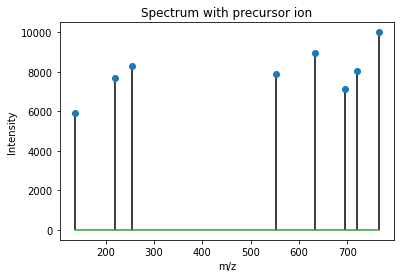

In [26]:
reader = mgf.read('test.mgf')
for spectrum in reader[0:1]: #read the first uncalibrated spectrum 
    print("Precursor m/z =", spectrum["params"]["pepmass"][0])
    plot_spectrum_from_reader(spectrum, "Spectrum with precursor ion")

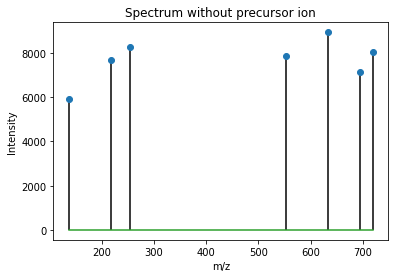

In [22]:
reader = mgf.read('precremoved.mgf')
for spectrum in reader[0:1]: #read the first uncalibrated spectrum 
    plot_spectrum_from_reader(spectrum, "Spectrum without precursor ion")

Precursor m/z = 399.349365234375


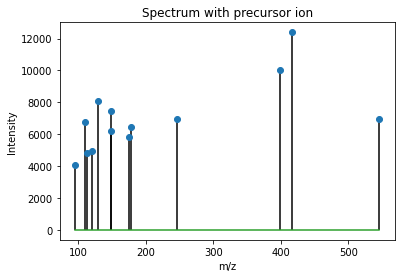

In [27]:
reader = mgf.read('test.mgf')
for spectrum in reader[1:2]: #read the first uncalibrated spectrum 
    print("Precursor m/z =", spectrum["params"]["pepmass"][0])
    plot_spectrum_from_reader(spectrum, "Spectrum with precursor ion")

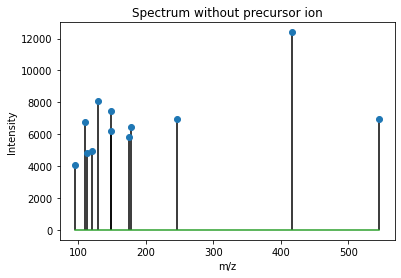

In [25]:
reader = mgf.read('precremoved.mgf')
for spectrum in reader[1:2]: #read the first uncalibrated spectrum 
    plot_spectrum_from_reader(spectrum, "Spectrum without precursor ion")

In [247]:
import time
start = time.time()
remove_precursor_peak_1("data.mgf", "prec_removed_long.mgf", 10, "ppm")
end = time.time()
print ("Time elapsed removing precursor peak from mgf file of 151M:", end - start)

Time elapsed removing precursor peak from mgf file of 151M: 197.07010889053345
